##### Recharge and Particles - Self Check Example

## Model Description 
This is a steady state box model with recharge

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = 100 m  

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is no flow (i.e. a closed basin) 
 - Left boundary is a constant head of 70 m relative to the datum, which is located at the bottom of the domain. 
 - Recharge occurs at a rate of 1E-4 m/d uniformly across the domain
 
#### Agricultural Scenarios: 
Scenario 1: 
 - Un-irrigated field with ET
     - Lower left corner (400,900) Upper Right Corner (1500,1600) (locations given as x,y)
     - ET rate 1e-3 m/day
     - Extinction depth 100 m
 - Pumping well
     - Located at (950, 1250)
     - Puping at a rate of 770 m^3/day (Equvalent to 1e-3m/day over the ag area which is 77,000m^2)

## 1. Setup the environment

In [31]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Setup the input variables 

In [2]:
## Discritization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x diretion 
dy= 100 #width of grid cells in y diretion 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 100.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_horiz = 1.    #horizontal hydraulic conductivity 
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## Recharge
recharge = 1e-4 #m/day #recharge in this model (because we're not using a vadose zone package)
#means that our specified recharge is being applied directly at wherever the water table is (drape)
#so we assume all specified recharge reaches water table, greatest limitation of modflow
#is it only specifies saturated flow without additional packages
#ET
#like recharge, ET is an areal phenomenon and can only be withdrawn from one cell
#in the vertical direction
ET = 1e-4 #m/day #the lower ET rate
ET2 = 1e-3 #m/day #the higher ET rate
#multiplied by 100x100 grid cells, we end up getting 10m3/day per cell
#we have 77 cells, so if we multiply we assume we get 770m^3/day, but actually
# we get less, 564m^3/day, this is because of extinction depth
#ET surface is when water table is at land surface, defaults to model surface
#if your water table is below this surface, it will scale DOWN your rate,
#this is because our water table never hits the surface
#lower ET rates where water table is lower, you don't hit this peak rate specified

ET_all=[[0, 0], [5000, 5000]] #lower left and upper right corners of ET in xy coordinate
ET_section1 = [[0,0],[5000,2000]]
ET_section2=[[0, 2000], [5000, 3000]]
ET_section3 = [[0,3000],[5000,5000]]
extinction_depth = 100
extinction_depth2 = 50

#extinction depth is the depth where if our water table is below that, our
#ET will be ZERO #between surface and extinction depth is just a linear interpolation

#you COULD have multiple ET zones with different rates and different extinction depths
#this would depend a lot on your surface plant cover(Ex. grassland vs. forest)

## Boundary conditions
h_left=70

## 3. Setup and run MODFLOW for the ET scenario 1 

In [3]:
#Initialize the model
modelnameE = "ET_Model_Scenario1"
moddir="/Users/condongroup/Documents/groundwater_modeling/modflow/pymake/examples/mf2005"
me = flopy.modflow.Modflow(modelnameE, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=me, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(me, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(me, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge #recharge everywhere 
#rech_zone[int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = 0 #set recharge to 0 inside ET zone
rch = flopy.modflow.mfrch.ModflowRch(model=me, rech=rech_zone, ipakcb=53)     #create rch object

#ET
ET_rows=(np.floor(nrow-ET_all[1][1]/dy),np.floor(nrow-ET_all[0][1]/dy)) #convert the y locations to rows, range rows I care about
ET_cols=(np.floor(ET_all[0][0]/dx),np.floor(ET_all[1][0]/dx)) #range cols I care about
ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET # assign ET rate to the ET zone #referencing the matrix chunk that the field covers
evt = flopy.modflow.mfevt.ModflowEvt(me, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=me, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=me)

#write the inputs
me.write_input()    

#Run the model 
success, mfoutput = me.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


print(ET_rows)
print(ET_cols)

FloPy is using the following  executable to run the model: /Users/condongroup/Documents/groundwater_modeling/modflow/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ET_Model_Scenario1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/03/04  8:30:09

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/03/04  8:30:09
 Elapsed run time:  0.018 Seconds

  Normal termination of simulation
(0.0, 50.0)
(0.0, 50.0)


## 4. Setup and run MODFLOW for the ET scenario 2

In [5]:
#Initialize the model
modelnameE = "ET_Model_Scenario2"
moddir="/Users/condongroup/Documents/groundwater_modeling/modflow/pymake/examples/mf2005"
me2 = flopy.modflow.Modflow(modelnameE, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=me2, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(me2, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(me2, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge #recharge everywhere 
#rech_zone[int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = 0 #set recharge to 0 inside ET zone
rch = flopy.modflow.mfrch.ModflowRch(model=me2, rech=rech_zone, ipakcb=53)     #create rch object

#ET
ET_rows2=(np.floor(nrow-ET_section2[1][1]/dy),np.floor(nrow-ET_section2[0][1]/dy)) #convert the y locations to rows, range rows I care about
ET_cols2=(np.floor(ET_section2[0][0]/dx),np.floor(ET_section2[1][0]/dx)) #range cols I care about

ET_zone2 = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone2[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET
ET_zone2[0,int(ET_rows2[0]):int(ET_rows2[1]), int(ET_cols2[0]):int(ET_cols2[1])] = ET2

evt2 = flopy.modflow.mfevt.ModflowEvt(me2, surf=ztop, evtr=ET_zone2, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=me2, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=me2)

#write the inputs
me2.write_input()    

#Run the model 
success, mfoutput = me2.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /Users/condongroup/Documents/groundwater_modeling/modflow/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ET_Model_Scenario2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/03/04  8:34:59

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/03/04  8:34:59
 Elapsed run time:  0.025 Seconds

  Normal termination of simulation


## 5. Setup and run MODFLOW for the ET scenario 3

In [7]:
#Initialize the model
modelnameE = "ET_Model_Scenario3"
moddir="/Users/condongroup/Documents/groundwater_modeling/modflow/pymake/examples/mf2005"
me3 = flopy.modflow.Modflow(modelnameE, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=me3, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(me3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(me3, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge #recharge everywhere 
#rech_zone[int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = 0 #set recharge to 0 inside ET zone
rch = flopy.modflow.mfrch.ModflowRch(model=me3, rech=rech_zone, ipakcb=53)     #create rch object

#ET
ET_rows2=(np.floor(nrow-ET_section2[1][1]/dy),np.floor(nrow-ET_section2[0][1]/dy)) #convert the y locations to rows, range rows I care about
ET_cols2=(np.floor(ET_section2[0][0]/dx),np.floor(ET_section2[1][0]/dx)) #range cols I care about

ET_zone3 = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone3[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET
ET_zone3[0,int(ET_rows2[0]):int(ET_rows2[1]), int(ET_cols2[0]):int(ET_cols2[1])] = ET2

extinction_depth_matrix = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
extinction_depth_matrix[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = extinction_depth
extinction_depth_matrix[0,int(ET_rows2[0]):int(ET_rows2[1]), int(ET_cols2[0]):int(ET_cols2[1])] = extinction_depth2 

evt3 = flopy.modflow.mfevt.ModflowEvt(me3, surf=ztop, evtr=ET_zone2, exdp=extinction_depth_matrix, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=me3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=me3)

#write the inputs
me3.write_input()    

#Run the model 
success, mfoutput = me3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /Users/condongroup/Documents/groundwater_modeling/modflow/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ET_Model_Scenario3.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/03/04  8:35:47

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/03/04  8:35:47
 Elapsed run time:  0.025 Seconds

  Normal termination of simulation


# 5. Add particles to both scenarios
### Setup the particles for all scenarios

In [8]:
moddirmp="/Users/condongroup/Documents/groundwater_modeling/modflow/pymake/examples/mp7"

#Make a group of particles - note we can use these for both simulations
locsb = [[0, 0, 0, 0, nrow - 1, ncol-1]] #Set the rante of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=1) #Number of part per cell
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb]) #setup theparticles
pg1 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg1]
#drape means apply recharge wherever you find your water table
defaultiface = {'RECHARGE': 6, 'ET': 6}#default is 6, meaning apply to top face of cell

### Run the ET scenario 1

In [9]:
modelnameE = "ET_Model_Scenario1"
mpnameE=os.path.join(modelnameE + '_mp')
print(mpnameE)
mpe = flopy.modpath.Modpath7(modelname=modelnameE + '_mp', flowmodel=me, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mpe, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mpe, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)


mpe.add_package(rch)
mpe.add_package(evt)
mpe.write_input()
mpe.run_model()
mpe.get_package_list()

ET_Model_Scenario1_mp
FloPy is using the following  executable to run the model: /Users/condongroup/Documents/groundwater_modeling/modflow/pymake/examples/mp7

MODPATH Version 7.2.001   
Program compiled Jan 23 2020 13:28:09 with GFORTRAN compiler (ver. 8.3.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      2500 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.         

['MPBAS', 'MPSIM', 'RCH', 'EVT']

#### Run the ET scenario 2

In [10]:
modelnameE2 = "ET_Model_Scenario2"
mpnameE2=os.path.join(modelnameE2 + '_mp')
print(mpnameE2)
mpe2 = flopy.modpath.Modpath7(modelname=modelnameE2 + '_mp', flowmodel=me2, exe_name=moddirmp)
mpbas2 = flopy.modpath.Modpath7Bas(mpe2, porosity=n, defaultiface=defaultiface)
mpsim2 = flopy.modpath.Modpath7Sim(mpe2, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)


mpe2.add_package(rch)
mpe2.add_package(evt2)
mpe2.write_input()
mpe2.run_model()
mpe2.get_package_list()

ET_Model_Scenario2_mp
FloPy is using the following  executable to run the model: /Users/condongroup/Documents/groundwater_modeling/modflow/pymake/examples/mp7

MODPATH Version 7.2.001   
Program compiled Jan 23 2020 13:28:09 with GFORTRAN compiler (ver. 8.3.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      2500 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.         

['MPBAS', 'MPSIM', 'RCH', 'EVT']

### Run the ET scenario 3

In [11]:
modelnameE3 = "ET_Model_Scenario3"
mpnameE3=os.path.join(modelnameE3 + '_mp')
print(mpnameE3)
mpe3 = flopy.modpath.Modpath7(modelname=modelnameE3 + '_mp', flowmodel=me3, exe_name=moddirmp)
mpbas3 = flopy.modpath.Modpath7Bas(mpe3, porosity=n, defaultiface=defaultiface)
mpsim3 = flopy.modpath.Modpath7Sim(mpe3, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)


mpe3.add_package(rch)
mpe3.add_package(evt3)
mpe3.write_input()
mpe3.run_model()
mpe3.get_package_list()

ET_Model_Scenario3_mp
FloPy is using the following  executable to run the model: /Users/condongroup/Documents/groundwater_modeling/modflow/pymake/examples/mp7

MODPATH Version 7.2.001   
Program compiled Jan 23 2020 13:28:09 with GFORTRAN compiler (ver. 8.3.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      2500 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.         

['MPBAS', 'MPSIM', 'RCH', 'EVT']

# 6. Read in the outputs

### For the ET Scenario for model 1

In [54]:
# Head
headobjE = bf.HeadFile(modelnameE+'.hds')    #reads the binary head file
timesE = headobjE.get_times()                #returns a list of timesteps
headE = headobjE.get_data(totim=timesE[-1])        #returns a numpy array of heads for specified time (last timestep)

#Water balance
budgobjE = bf.CellBudgetFile(modelnameE+'.cbc')   #reads the cell budget file    
#print(budgobjE.get_unique_record_names())
kstpkper_listE = budgobjE.get_kstpkper()          #returns a list of stress periods & timesteps
frfE = budgobjE.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fffE = budgobjE.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
etE = budgobjE.get_data(text='ET', totim=1.0) #returns an array of flow rates for front face of cells 
rechargeE = budgobjE.get_data(text='RECHARGE', totim=1.0) #returns an array of flow rates for front face of cells 
#53 int means that ET and recharge ALSO written to budget file, change to zero if you don;t want it written here

#Particle pathlines
fpthE = os.path.join(mpnameE + '.mppth')
pE = flopy.utils.PathlineFile(fpthE)

#Particle endpoints
fpthE = os.path.join(mpnameE + '.mpend')
eE = flopy.utils.EndpointFile(fpthE, verbose=False)

#make a subset which is all the particles
pallE = pE.get_alldata()  
eallE = eE.get_alldata()  

elocs = []
enodes = []
for idx in range(int(ET_rows2[0]), int(ET_rows2[1])):
    for idy in range(int(ET_cols2[0]), int(ET_cols2[1])):
        elocs.append((0, idx, idy))
        enodes.append(me.dis.get_node([(0,idx,idy)]))
petzoneE = pE.get_destination_pathline_data(dest_cells=enodes)
eetzoneE = eE.get_destination_endpoint_data(dest_cells=enodes)

### For the ET Scenario for model 2

In [13]:
# Head
headobjE2 = bf.HeadFile(modelnameE2+'.hds')    #reads the binary head file
timesE2 = headobjE2.get_times()                #returns a list of timesteps
headE2 = headobjE2.get_data(totim=timesE2[-1])        #returns a numpy array of heads for specified time (last timestep)

#Water balance
budgobjE2 = bf.CellBudgetFile(modelnameE2+'.cbc')   #reads the cell budget file    
#print(budgobjE.get_unique_record_names())
kstpkper_listE2 = budgobjE2.get_kstpkper()          #returns a list of stress periods & timesteps
frfE2 = budgobjE2.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fffE2 = budgobjE2.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
etE2 = budgobjE2.get_data(text='ET', totim=1.0) #returns an array of flow rates for front face of cells 
rechargeE2 = budgobjE2.get_data(text='RECHARGE', totim=1.0) #returns an array of flow rates for front face of cells 
#53 int means that ET and recharge ALSO written to budget file, change to zero if you don;t want it written here

#Particle pathlines
fpthE2 = os.path.join(mpnameE2 + '.mppth')
pE2 = flopy.utils.PathlineFile(fpthE2)

#Particle endpoints
fpthE2 = os.path.join(mpnameE2 + '.mpend')
eE2 = flopy.utils.EndpointFile(fpthE2, verbose=False)

#make a subset which is all the particles
pallE2 = pE2.get_alldata()  
eallE2 = eE2.get_alldata()

#make a subset which is all the particles ending in the ET zone
elocs2 = []
enodes2 = []
for idx in range(int(ET_rows2[0]), int(ET_rows2[1])):
    for idy in range(int(ET_cols2[0]), int(ET_cols2[1])):
        elocs2.append((0, idx, idy))
        enodes2.append(me.dis.get_node([(0,idx,idy)]))
petzoneE2 = pE2.get_destination_pathline_data(dest_cells=enodes2)
eetzoneE2 = eE2.get_destination_endpoint_data(dest_cells=enodes2) 

### For the ET Scenario for model 3

In [14]:
# Head
headobjE3 = bf.HeadFile(modelnameE3+'.hds')    #reads the binary head file
timesE3 = headobjE3.get_times()                #returns a list of timesteps
headE3 = headobjE3.get_data(totim=timesE3[-1])        #returns a numpy array of heads for specified time (last timestep)

#Water balance
budgobjE3 = bf.CellBudgetFile(modelnameE3+'.cbc')   #reads the cell budget file    
#print(budgobjE.get_unique_record_names())
kstpkper_listE3 = budgobjE3.get_kstpkper()          #returns a list of stress periods & timesteps
frfE3 = budgobjE3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fffE3 = budgobjE3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
etE3 = budgobjE3.get_data(text='ET', totim=1.0) #returns an array of flow rates for front face of cells 
rechargeE3 = budgobjE3.get_data(text='RECHARGE', totim=1.0) #returns an array of flow rates for front face of cells 
#53 int means that ET and recharge ALSO written to budget file, change to zero if you don;t want it written here

#Particle pathlines
fpthE3 = os.path.join(mpnameE3 + '.mppth')
pE3 = flopy.utils.PathlineFile(fpthE3)

#Particle endpoints
fpthE3 = os.path.join(mpnameE3 + '.mpend')
eE3 = flopy.utils.EndpointFile(fpthE3, verbose=False)

#make a subset which is all the particles
pallE3 = pE3.get_alldata()  
eallE3 = eE3.get_alldata()

#make a subset which is all the particles ending in the ET zone

elocs3 = []
enodes3 = []
for idx in range(int(ET_rows2[0]), int(ET_rows2[1])):
    for idy in range(int(ET_cols2[0]), int(ET_cols2[1])):
        elocs3.append((0, idx, idy))
        enodes3.append(me.dis.get_node([(0,idx,idy)]))
        
petzoneE3 = pE3.get_destination_pathline_data(dest_cells=enodes2)
eetzoneE3 = eE3.get_destination_endpoint_data(dest_cells=enodes2) 

#lower_petzoneE3 = pE3.get_destination_pathline_data(dest_cells=enodes3)
#lower_eetzoneE3 = eE3.get_destination_endpoint_data(dest_cells=enodes3) 

# 6. Plotting
#### Plot the grid and ibound

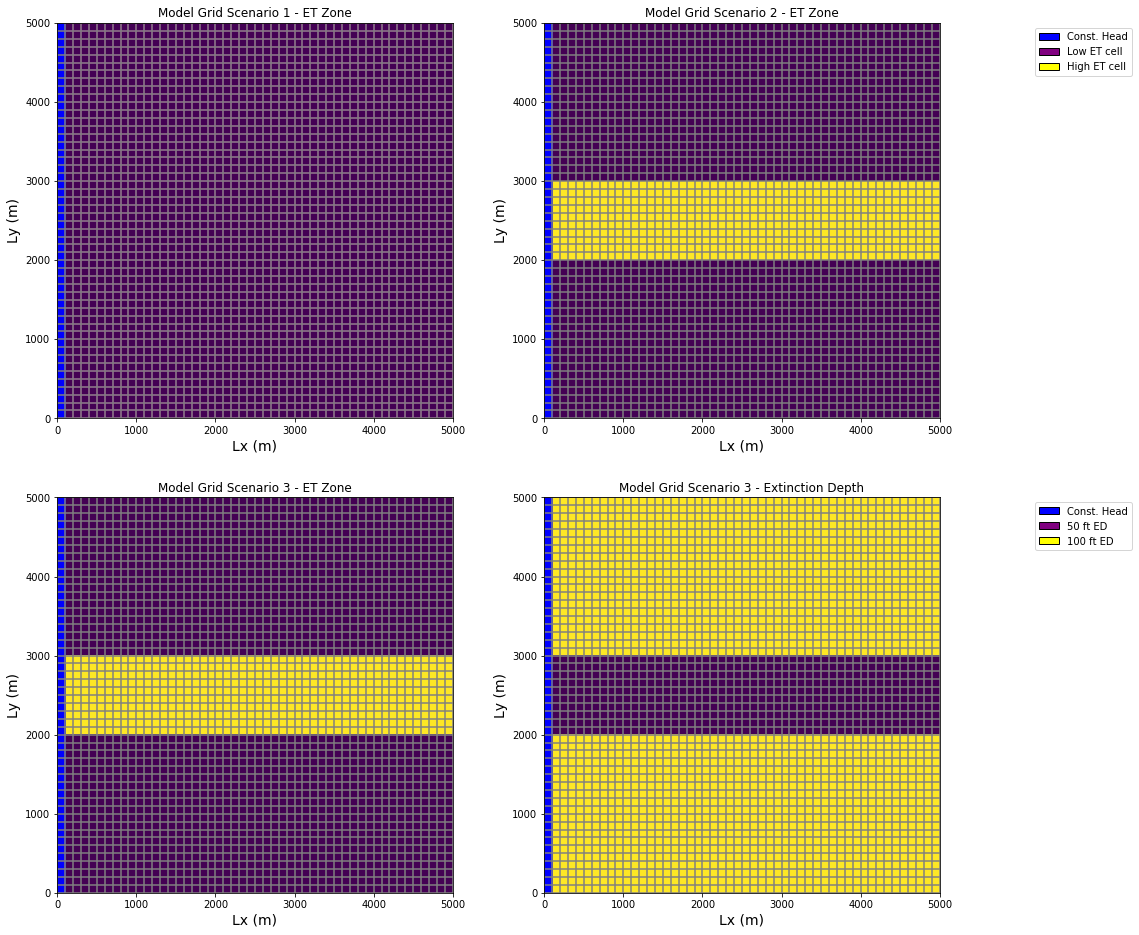

In [45]:
fig = plt.figure(figsize=(16,16)) #set size of each subplot

#Scenario 1 ET zone
ax = fig.add_subplot(2,2,1,aspect = 'equal')
modelmap = flopy.plot.PlotMapView(model=me)
quadmesh = modelmap.plot_array(ET_zone, color='purple')
#cb = plt.colorbar(quadmesh, shrink=0.5)
quadmesh = modelmap.plot_ibound()
grid = modelmap.plot_grid()

t = ax.set_title("Model Grid Scenario 1 - ET Zone")
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='purple',label='Low ET cell',ec='black'),
                   mp.patches.Patch(color='yellow',label='High ET cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))

#Scenario 2 ET zone
ax = fig.add_subplot(2,2,2,aspect = 'equal')
modelmap = flopy.plot.PlotMapView(model=me2)
quadmesh = modelmap.plot_array(ET_zone2)
#cb = plt.colorbar(quadmesh, shrink=0.5)
quadmesh = modelmap.plot_ibound()
grid = modelmap.plot_grid()

t = ax.set_title("Model Grid Scenario 2 - ET Zone")
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='purple',label='Low ET cell',ec='black'),
                   mp.patches.Patch(color='yellow',label='High ET cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))

#Scenario 3 ET zone
ax = fig.add_subplot(2,2,3,aspect = 'equal')
modelmap = flopy.plot.PlotMapView(model=me3)
quadmesh = modelmap.plot_array(ET_zone3)
#cb = plt.colorbar(quadmesh, shrink=0.5)
quadmesh = modelmap.plot_ibound()
grid = modelmap.plot_grid()

t = ax.set_title("Model Grid Scenario 3 - ET Zone")
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='purple',label='Low ET cell',ec='black'),
                   mp.patches.Patch(color='yellow',label='High ET cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))

#Extinction depth
ax = fig.add_subplot(2,2,4,aspect = 'equal')
modelmap = flopy.plot.PlotMapView(model=me3)
quadmesh = modelmap.plot_array(extinction_depth_matrix)
#cb = plt.colorbar(quadmesh, shrink=0.5)
quadmesh = modelmap.plot_ibound()
grid = modelmap.plot_grid()

t = ax.set_title("Model Grid Scenario 3 - Extinction Depth")
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='purple',label='50 ft ED',ec='black'),
                   mp.patches.Patch(color='yellow',label='100 ft ED',ec='black')],
                   bbox_to_anchor=(1.5,1.0))

plt.savefig('ModelGrids.png')

###  Calculate the water blance

In [15]:
print("ET Scenario 1")
print("Total Reacharge", np.sum(rechargeE[0][1]))#for this data type, each dim needs its own square bracket
print("Total ET", np.sum(etE[0][1])) 
print()
print("ET Scenario 2")
print("Total Reacharge", np.sum(rechargeE2[0][1]))#for this data type, each dim needs its own square bracket
print("Total ET", np.sum(etE2[0][1])) 
print()
print("ET Scenario 3")
print("Total Reacharge", np.sum(rechargeE3[0][1]))#for this data type, each dim needs its own square bracket
print("Total ET", np.sum(etE3[0][1])) 


ET Scenario 1
Total Reacharge 2450.0
Total ET -1789.3469

ET Scenario 2
Total Reacharge 2450.0
Total ET -4149.962

ET Scenario 3
Total Reacharge 2450.0
Total ET -2976.3096


### Plot particle pathlines

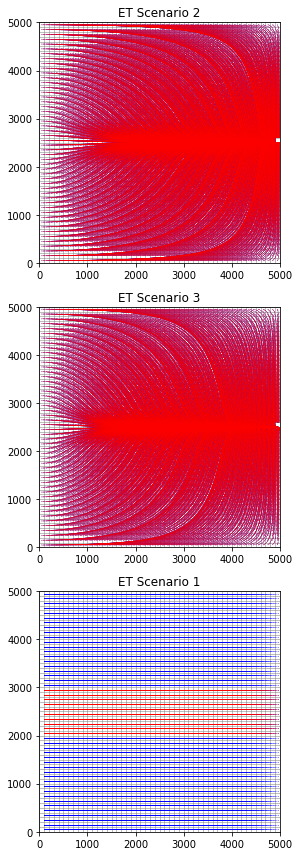

In [56]:
f, axes = plt.subplots(ncols=1, nrows=3, figsize=(12, 12))

ax = axes[0]
ax.set_aspect('equal')
ax.set_title('ET Scenario 2')
mm = flopy.plot.PlotMapView(model=me2, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pallE2, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(petzoneE2, layer='all', color='red', lw=0.5, linestyle=':', label='captured by well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)


ax = axes[1]
ax.set_aspect('equal')
ax.set_title('ET Scenario 3')
mm = flopy.plot.PlotMapView(model=me3, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pallE3, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(petzoneE3, layer='all', color='red', lw=0.5, linestyle=':', label='captured by well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)

ax = axes[2]
ax.set_aspect('equal')
ax.set_title('ET Scenario 1')
mm = flopy.plot.PlotMapView(model=me, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pallE, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(petzoneE, layer='all', color='red', lw=0.5, linestyle=':', label='captured by well') # ,marker='o', m
plt.tight_layout();
plt.savefig('Pathlines.png')

### Plot the ages

In [ ]:
# f, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

# ax = axes[0]
# ax.set_aspect('equal')
# ax.set_title('ET Scenario Flowlines')
# mm = flopy.plot.PlotMapView(model=me, ax=ax)
# mm.plot_grid(lw=0.5)
# mm.plot_endpoint(eallE, direction='starting', colorbar=True, shrink=0.5);
# #mm.plot_endpoint(eetzoneE, direction='starting', colorbar=True, shrink=0.5);
# #mm.ax.legend();

# ax = axes[1]
# ax.set_aspect('equal')
# ax.set_title('Well Scenario Flowlines')
# mm = flopy.plot.PlotMapView(model=mw, ax=ax)
# mm.plot_grid(lw=0.5)
# mm.plot_endpoint(eallW, direction='starting', colorbar=True, shrink=0.5);
# #mm.plot_endpoint(eetzoneW, direction='starting', colorbar=True, shrink=0.5);
# #mm.ax.legend();

# plt.tight_layout();

# #print(eetzoneW['particleid'])
# print(eetzoneE['particleid'])

### Plot head transect

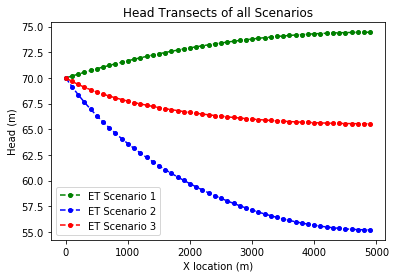

In [47]:
fig4 = plt.figure() 

ax = axes[0]
x=np.arange(0,5000,100) 
plt.plot(x,headE[0,25,:],marker='o', color='green', markersize=4, linestyle='--', label="ET Scenario 1")
plt.plot(x,headE2[0,25,:],marker='o', color='blue', markersize=4, linestyle='--', label="ET Scenario 2")
plt.plot(x,headE3[0,25,:],marker='o', color='red', markersize=4, linestyle='--', label="ET Scenario 3")
plt.title('Head Transects of all Scenarios')
plt.xlabel('X location (m)')
plt.ylabel('Head (m)')
plt.legend()
plt.savefig('Head_Transect.png')

